<a href="https://colab.research.google.com/github/sakagami0615/QLearnReversi/blob/master/QLearnReversi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リバーシの強化学習

*   目標<br>
勝率の高いリバーシの強化学習モデルを作成し、対戦してみる。<br><br>
*   やること<br>
 **[完了]** リバーシを実装<br>
 **[完了]** Q学習を実装<br>
 **[未完]** 対戦用のランダムと竜王MinMaxを実装（時間がないため、保留）<br>
 **[完了]** Q学習でモデルを作成<br>
 **[完了]** ユーザvsAIを実践<br><br>

参考URL<br>
+ https://qiita.com/gatchaman-20140215/items/0bae224174c850b7c9f6
+ https://github.com/gatchaman-20140215/machine-learning/blob/master/Google%20Colaboratory/4x4reversi_Q_Learning.ipynb

## リバーシを実装

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# numpy配列の左右スライド用関数
# (オーバーフローもしくはアンダーフローは切り捨て、溢れた分だけ0埋めする)
def left_slide(array, shift, fill_value=0):
    return np.concatenate((array[shift:], np.full(shift, fill_value)))

def right_slide(array, shift, fill_value=0):
    return np.concatenate((np.full(shift, fill_value), array[:-shift]))

In [ ]:
import re

class Reversi:
    """
    リバーシクラス
    """

    def __init__(self):

        # 駒の状態値
        self.pieces = {key:id for (key, id) in zip(['EMPTY', 'BLACK', 'WHITE'], range(3))}

        # 駒の状態キー(駒の場所を表している)
        self.state_keys = [
            'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1',
            'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2',
            'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3',
            'A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4',
            'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5',
            'A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6',
            'A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7',
            'A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'
        ]
        # 盤面のサイズ
        self.board_size = 8

        # 探索方向(水平、垂直、左斜め、右斜め)
        self.directions = [1, self.board_size, self.board_size + 1, self.board_size - 1]

        # 番兵マスク
        self.wall_masks = [
            np.array([re.search('A|H', key) == None for key in self.state_keys]),
            np.array([re.search('1|8', key) == None for key in self.state_keys]),
            np.array([re.search('A|H|1|8', key) == None for key in self.state_keys]),
            np.array([re.search('A|H|1|8', key) == None for key in self.state_keys])
        ]

        self.initialize()

    
    def initialize(self):
        """
        # 初期化処理
        """
        # パスカウンター
        self.pass_count = 0
        # 盤面およびターンプレイヤー初期化
        self.board = {key:self.pieces['EMPTY'] for key in self.state_keys}
        self.board['D4'] = self.board['E5'] = self.pieces['BLACK']
        self.board['E4'] = self.board['D5'] = self.pieces['WHITE']
        self.turn_piece = self.pieces['BLACK']
        self.opp_piece = self.pieces['BLACK'] + self.pieces['WHITE'] - self.turn_piece
    
    def bit_board(self, piece):
        """
        盤面辞書から、指定された駒のビットボードを取得
        """
        return np.array([self.board[key] == piece for key in self.state_keys])

    def dict_board(self, turn_bit_board, opp_bit_board):
        """
        ビットボードから盤面辞書を取得
        """
        array_board = np.zeros(self.board_size*self.board_size, dtype=np.int64)
        array_board += turn_bit_board*self.turn_piece
        array_board += opp_bit_board*self.opp_piece
        return {key: piece for (key, piece) in zip(self.state_keys, array_board)}
    
    def piece_count(self):
        """
        駒数を取得
        """
        return sum([1 for data in self.board.values() if data > self.pieces['EMPTY']])
    
    def turn_piece_count(self):
        """
        ターンプレイヤーの駒数を取得
        """
        return sum([1 for data in self.board.values() if data == self.turn_piece])
    
    def opp_piece_count(self):
        """
        相手プレイヤーの駒数を取得
        """
        return sum([1 for data in self.board.values() if data == self.opp_piece])
    

    def turn_change(self):
        """
        ターンプレイヤーを入れ替える
        """
        self.opp_piece = self.turn_piece
        self.turn_piece = self.pieces['BLACK'] + self.pieces['WHITE'] - self.turn_piece
    

    def legal_actions(self):
        """
        合法手のアクションを取得
        """        
        # 全駒のフラグ、自分駒の有無フラグ、相手駒の有無フラグ、合法手マスクを初期化する
        turn_bit = self.bit_board(self.turn_piece)
        opp_bit = self.bit_board(self.opp_piece)
        piece_bit = turn_bit | opp_bit
        legal_mask = np.zeros(self.board_size*self.board_size, dtype=np.int64)

        # 縦、横、左斜め、右斜めで反転を確認
        for (direction, wall_mask) in zip(self.directions, self.wall_masks):
            # 番兵マスクを反映
            enable_opp_bit = opp_bit & wall_mask
            # 反転マスクを初期化
            flip_mask = (left_slide(turn_bit, direction) | right_slide(turn_bit, direction)) & enable_opp_bit
            # 連続している相手駒があればマスクに格納
            for _ in range(self.board_size - 2):
                flip_mask |= (left_slide(flip_mask, direction) | right_slide(flip_mask, direction)) & enable_opp_bit
            
            # ターンプレイヤーが駒配置可能な場所をマスクとして取得
            flip_mask = left_slide(flip_mask, direction) | right_slide(flip_mask, direction)
            legal_mask |= flip_mask & (~piece_bit)
        
        # 合法手マスクをアクションのキーに変換
        legal_indexs = np.where(legal_mask == True)[0]
        legal_keys = [self.state_keys[legal_index] for legal_index in legal_indexs]
        return legal_keys      


    def move(self, action):
        """
        駒を置き、反転処理を実施
        """
        # アクションをビット表現に変換
        action_bit = [key == action for key in self.state_keys]

        # 全駒のフラグ、自分駒の有無フラグ、相手駒の有無フラグ、合法手マスクを初期化する
        turn_bit = self.bit_board(self.turn_piece)
        opp_bit = self.bit_board(self.opp_piece)
        move_mask = np.zeros(self.board_size*self.board_size, dtype=np.int64)

        # 縦、横、左斜め、右斜めで反転を確認
        for (direction, wall_mask) in zip(self.directions, self.wall_masks):
            # 番兵マスクを反映
            enable_opp_bit = opp_bit & wall_mask
            # 反転探索マスクを初期化
            action_mask = (left_slide(action_bit, direction) | right_slide(action_bit, direction)) & enable_opp_bit
            edge_mask = (left_slide(turn_bit, direction) | right_slide(turn_bit, direction)) & enable_opp_bit

            # 連続している相手駒があればマスクに格納
            for _ in range(self.board_size - 1):
                action_mask |= (left_slide(action_mask, direction) | right_slide(action_mask, direction)) & enable_opp_bit
                edge_mask |= (left_slide(edge_mask, direction) | right_slide(edge_mask, direction)) & enable_opp_bit
            
            # アクションビットから探索した連続相手駒とエッジビットから探索した連続相手駒のマスクから反転マスクを取得
            # アクションビット忘れずに反転マスクに考慮
            move_mask |= action_bit | (action_mask & edge_mask)

            
        # 合法手マスクをアクションのキーに変換し、駒の反転を実施
        move_indexs = np.where(move_mask == True)[0]
        move_keys = [self.state_keys[move_index] for move_index in move_indexs]
        for key in move_keys:
            self.board[key] = self.turn_piece
        

    def state(self):
        """
        状態(盤面、合法手アクション、ターンプレイヤー)を返す
        """
        flatten_board = [self.board[key] for key in self.state_keys]
        board_code = ''.join(map(str, flatten_board))
        state = (self.turn_piece, board_code)
        return state
    
    def reward(self):
        """
        価値を返す
        """
        if not self.is_done():
            reward = {self.pieces['BLACK']: 0, self.pieces['WHITE']: 0}
            return reward
        else:
            if self.turn_piece_count() > self.opp_piece_count():
                reward = {self.turn_piece: 1, self.opp_piece: -1}
                return reward
            elif self.turn_piece_count() < self.opp_piece_count():
                reward = {self.turn_piece: -1, self.opp_piece: 1}
                return reward
            else:
                reward = {self.turn_piece: 0, self.opp_piece: 0}
                return reward
    
    def is_done(self):
        """
        ゲームの終了を判断する
        """
        empty_count = sum([1 for data in self.board.values() if data == self.pieces['EMPTY']])
        if (empty_count == 0) or (self.pass_count >= 2):
            return True
        else:
            return False

    def step(self, action):
        """
        ターンプレイヤーの1ステップの動作を実施
        """
        # パスはactionがNoneかどうかで判定
        if not action:
            state = self.state()
            self.pass_count += 1
            self.turn_change()
            return state, self.reward()
        else:
            self.move(action)
            state = self.state()
            self.pass_count = 0
            self.turn_change()
            return state, self.reward()

    def show_board(self, display_black='●', display_white='○', display_legal='★'):
        """
        状態と合法手を表示する
        """
        legal_actions = self.legal_actions()
        legal_datas = [key in legal_actions for key in self.state_keys]
        piece_datas = [self.board[key] for key in self.state_keys]
        
        def data2view(piece_data, legal_data):
            if piece_data == self.pieces['BLACK']: return display_black
            elif piece_data == self.pieces['WHITE']: return display_white
            elif legal_data: return display_legal
            else: return '-'
        
        view_datas = np.array([data2view(piece, legal) for (piece, legal) in zip(piece_datas, legal_datas)])
        view_board = view_datas.reshape(self.board_size, self.board_size)
        
        index = [i + 1 for i in range(self.board_size)]
        column = [chr(ord('A')+i) for i in range(self.board_size)]
        return pd.DataFrame(view_board, index, column)

In [ ]:
reversi = Reversi()
reversi.show_board()

,A,B,C,D,E,F,G,H
1,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-
3,-,-,-,-,★,-,-,-
4,-,-,-,●,○,★,-,-
5,-,-,★,○,●,-,-,-
6,-,-,-,★,-,-,-,-
7,-,-,-,-,-,-,-,-
8,-,-,-,-,-,-,-,-


### 動作確認 - part1
盤面描画、合法手取得

In [ ]:
# 描画
reversi = Reversi()
reversi.show_board()

,A,B,C,D,E,F,G,H
1,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-
3,-,-,-,-,★,-,-,-
4,-,-,-,●,○,★,-,-
5,-,-,★,○,●,-,-,-
6,-,-,-,★,-,-,-,-
7,-,-,-,-,-,-,-,-
8,-,-,-,-,-,-,-,-


In [ ]:
# 合法手を取得
legal_actions = reversi.legal_actions()
legal_actions

['E3', 'F4', 'C5', 'D6']

In [ ]:
# 適当に駒配置
reversi.move(legal_actions[0])
reversi.show_board()

,A,B,C,D,E,F,G,H
1,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-
3,-,-,-,-,●,-,-,-
4,-,-,-,●,●,-,-,-
5,-,-,★,○,●,-,-,-
6,-,-,★,★,-,-,-,-
7,-,-,-,-,-,-,-,-
8,-,-,-,-,-,-,-,-


### 動作確認 - part2
反転処理

In [ ]:
import sys
import unittest

class TestFlip(unittest.TestCase):

    def test_Case01_OnePieceFlipStraight(self):
        reversi = Reversi()
        expected = reversi.board.copy()
        expected['E4'] = reversi.pieces['BLACK']
        expected['E3'] = reversi.pieces['BLACK']

        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('E3')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)

    def test_Case02_OnePieceFlipDiagonal(self):
        reversi = Reversi()
        expected = reversi.board.copy()
        expected['D5'] = reversi.pieces['BLACK']
        expected['E4'] = reversi.pieces['BLACK']
        expected['F3'] = reversi.pieces['BLACK']

        reversi.board['D5'] = reversi.pieces['BLACK']
        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('F3')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)
    
    def test_Case03_MultiPieceFlipStraight(self):
        reversi = Reversi()
        expected = reversi.board.copy()
        expected['E4'] = reversi.pieces['BLACK']
        expected['E3'] = reversi.pieces['BLACK']
        expected['E2'] = reversi.pieces['BLACK']
        expected['E1'] = reversi.pieces['BLACK']

        reversi.board['E3'] = reversi.pieces['WHITE']
        reversi.board['E2'] = reversi.pieces['WHITE']
        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('E1')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)
    
    def test_Case04_MultiPieceFlipDiagonal(self):
        reversi = Reversi()
        expected = reversi.board.copy()
        expected['E4'] = reversi.pieces['BLACK']
        expected['F3'] = reversi.pieces['BLACK']
        expected['G2'] = reversi.pieces['BLACK']
        expected['H1'] = reversi.pieces['BLACK']

        reversi.board['E4'] = reversi.pieces['BLACK']
        reversi.board['F3'] = reversi.pieces['WHITE']
        reversi.board['G2'] = reversi.pieces['WHITE']
        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('H1')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)
    
    def test_Case05_MultiLineFlip(self):
        reversi = Reversi()
        expected = reversi.board.copy()
        expected['D1'] = reversi.pieces['BLACK']
        expected['E1'] = reversi.pieces['BLACK']
        expected['F1'] = reversi.pieces['BLACK']
        expected['G1'] = reversi.pieces['BLACK']
        
        expected['H5'] = reversi.pieces['BLACK']
        expected['H4'] = reversi.pieces['BLACK']
        expected['H3'] = reversi.pieces['BLACK']
        expected['H2'] = reversi.pieces['BLACK']
        
        expected['E4'] = reversi.pieces['BLACK']
        expected['F3'] = reversi.pieces['BLACK']
        expected['G2'] = reversi.pieces['BLACK']
        expected['H1'] = reversi.pieces['BLACK']

        reversi.board['D1'] = reversi.pieces['BLACK']
        reversi.board['E1'] = reversi.pieces['WHITE']
        reversi.board['F1'] = reversi.pieces['WHITE']
        reversi.board['G1'] = reversi.pieces['WHITE']
        
        reversi.board['H5'] = reversi.pieces['BLACK']
        reversi.board['H4'] = reversi.pieces['WHITE']
        reversi.board['H3'] = reversi.pieces['WHITE']
        reversi.board['H2'] = reversi.pieces['WHITE']
        
        reversi.board['E4'] = reversi.pieces['BLACK']
        reversi.board['F3'] = reversi.pieces['WHITE']
        reversi.board['G2'] = reversi.pieces['WHITE']
        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('H1')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)
    
    # 実際にバグが派生したケース
    def test_Case06_Other(self):
        black_states = ['A1', 'B1', 'C1', 'D1', 'E1',
                        'A2', 'B2', 'C2', 'D2', 'E2', 'F2',
                        'A3', 'B3', 'C3', 'D3', 'E3', 'F3',
                                          'D4', 'E4',             'H4',
                              'B5', 'C5', 'D5',       'F5', 'G5', 'H5',
                                                      'F6',       'H6']
        white_states = [                                          'H2',
                                                            'G3',
                                                      'F4',
                                                'E5',
                                          'D6',
                                                'E7']
        
        reversi = Reversi()
        for state in black_states:
            reversi.board[state] = reversi.pieces['BLACK']
        for state in white_states:
            reversi.board[state] = reversi.pieces['WHITE']
        expected = reversi.board.copy()

        expected['D6'] = reversi.pieces['BLACK']
        expected['E7'] = reversi.pieces['BLACK']
        expected['F8'] = reversi.pieces['BLACK']
        print()
        print('-'*100)
        print('[{}]'.format(sys._getframe().f_code.co_name))
        print(reversi.show_board('x', 'o', '*'))
        print('-'*10)
        reversi.step('F8')
        print(reversi.show_board('x', 'o', '*'))
        self.assertEqual(reversi.board, expected)    

In [ ]:
# unittestを実行
if __name__ == '__main__': unittest.main(argv=['first-arg-is-ignored'], exit=False)

......


----------------------------------------------------------------------------------------------------
[test_Case01_OnePieceFlipStraight]
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  -  *  -  -  -
4  -  -  -  x  o  *  -  -
5  -  -  *  o  x  -  -  -
6  -  -  -  *  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
----------
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  *  x  *  -  -
4  -  -  -  x  x  -  -  -
5  -  -  -  o  x  *  -  -
6  -  -  -  -  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -

----------------------------------------------------------------------------------------------------
[test_Case02_OnePieceFlipDiagonal]
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  -  *  *  -  -
4  -  -  -  x  o  *  -  -
5  -  -  -  x  x  -  -  -
6  -  -  -  -  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
----------
  


----------------------------------------------------------------------
Ran 6 tests in 0.239s

OK


### 動作確認 - part3
ランダム配置 vs. ランダム配置

In [ ]:
import random

reversi = Reversi()
print(reversi.show_board('x', 'o', '*'))

while not reversi.is_done():
    legal_actions = reversi.legal_actions()

    if len(legal_actions) > 0:
        action = np.random.choice(legal_actions)
    else:
        action = None

    reversi.step(action)
    print('-'*10)
    print(legal_actions)
    print(action)
    print(reversi.show_board('x', 'o', '*'))

print('{}:{}'.format(reversi.turn_piece, reversi.turn_piece_count()))
print('{}:{}'.format(reversi.opp_piece, reversi.opp_piece_count()))
reversi.show_board()

   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  -  *  -  -  -
4  -  -  -  x  o  *  -  -
5  -  -  *  o  x  -  -  -
6  -  -  -  *  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
----------
['E3', 'F4', 'C5', 'D6']
F4
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  *  -  *  -  -
4  -  -  -  x  x  x  -  -
5  -  -  -  o  x  *  -  -
6  -  -  -  -  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
----------
['D3', 'F3', 'F5']
F3
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  *  -  -
3  -  -  -  -  *  o  -  -
4  -  -  -  x  o  x  -  -
5  -  -  *  o  x  -  -  -
6  -  -  -  *  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
----------
['F2', 'E3', 'C5', 'D6']
F2
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  x  *  -
3  -  -  -  *  -  x  -  -
4  -  -  *  x  o  x  *  -
5  -  -  -  o  x  *  -  -
6  -  -  -  -  *  -  -  -
7  - 

,A,B,C,D,E,F,G,H
1,●,○,○,○,○,●,●,●
2,●,●,○,○,○,○,●,●
3,●,●,●,●,●,●,●,●
4,●,●,●,●,○,●,●,●
5,●,○,●,○,○,○,●,●
6,●,●,○,●,●,●,●,●
7,●,○,●,●,●,●,●,●
8,○,○,○,○,●,●,●,●


## Q学習を実装

In [ ]:
from tqdm import tqdm

class Environment:

    def __init__(self):
        self.history = []
    
    def run(self, black_agent, white_agent, num_episode=1000):

        reversi = Reversi()
        agent = {reversi.pieces['BLACK']: black_agent, reversi.pieces['WHITE']: white_agent}
        
        for episode in tqdm(range(num_episode)):
            
            reversi.initialize()

            while not reversi.is_done():
                state = reversi.state()
                actions = reversi.legal_actions()
                turn_piece = state[0]
                
                # 合法手がない場合はパスを実施
                if not actions:
                    reversi.step(None)
                else:
                    action = agent[turn_piece].policy(state, actions)

                    next_state, reward = reversi.step(action)
                    agent[turn_piece].update_q_function(state, action, next_state, reward[turn_piece])
            else:
                self.history.append(reward)
        
        return self.history


In [ ]:
class RandomAgent:
    
    def __init__(self):
        pass
    
    def policy(self, state, actions):
        return np.random.choice(actions)

    def update_q_function(self, state, action, next_state, reward):
        return None

In [ ]:
class QLearnAgent:
    
    def __init__(self, state_keys, epsilon=0.1, gamma=0.9, alpha=0.8, q_table={}, is_learn=True):
        self.q_table = q_table
        self.state_keys = state_keys
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.is_learn = is_learn
    

    def init_q_table(self, state):
        # テーブルに未登録の場合は、新規追加
        if not self.q_table.get(state):
            self.q_table[state] = {key: 0 for key in self.state_keys}

    def policy(self, state, actions):
        if self.is_learn and (np.random.random() < self.epsilon):
            return np.random.choice(actions)
        else:
            self.init_q_table(state)
            # 合法手のみのQテーブルを取得
            legal_q_table = {action: self.q_table[state][action] for action in actions}
            # Q値が最大となるアクション(駒配置場所)を取得
            return max(legal_q_table, key=legal_q_table.get)

    def update_q_function(self, state, action, next_state, reward): 
        self.init_q_table(state)
        self.init_q_table(next_state)
        
        #TODO: 次の手は相手だが、QはMaxでよいのか？
        gain = reward + self.gamma * max(self.q_table[next_state].values())
        self.q_table[state][action] += self.alpha * (gain - self.q_table[state][action])


### **Q学習を実施**

In [ ]:
env = Environment()

reversi = Reversi()

num_episode = 10000

# 黒手と白手のエージェントを設定
black_agent = QLearnAgent(reversi.state_keys)
white_agent = RandomAgent()
#black_agent = RandomAgent()
#white_agent = QLearnAgent(reversi.state_keys)

reward_log = env.run(black_agent, white_agent, num_episode)

100%|██████████| 10000/10000 [17:56<00:00,  9.29it/s]


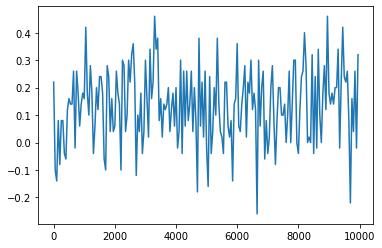

In [ ]:
# 黒手の学習結果を表示
interval = 50

black_reward_log = [log[1] for log in reward_log]

black_avg_reward = {}
for e in range(0, len(black_reward_log), interval):
    black_avg_reward[e] = np.mean(black_reward_log[e : e+interval])
pd.Series(black_avg_reward).plot()

In [ ]:
"""
# 白手の学習結果を表示
interval = 200

white_reward_log = [log[2] for log in reward_log]

white_avg_reward = {}
for e in range(0, len(white_reward_log), interval):
    white_avg_reward[e] = np.mean(white_reward_log[e : e+interval])
pd.Series(white_avg_reward).plot()
"""

'\ninterval = 200\n\nwhite_reward_log = [log[2] for log in reward_log]\n\nwhite_avg_reward = {}\nfor e in range(0, len(white_reward_log), interval):\n    white_avg_reward[e] = np.mean(white_reward_log[e : e+interval])\npd.Series(white_avg_reward).plot()\n'

### QTableの書き込み

In [ ]:
import pickle
from google.colab import drive

drive.mount('./gdrive')

# 学習結果の書き込み
with open('./gdrive/My Drive/Colab/develop/QLearn_Reversi/QTable_black_episode-{}.json'.format(num_episode), 'wb') as f:
    pickle.dump(black_agent.q_table, f)
#with open('./gdrive/My Drive/Colab/develop/QLearn_Reversi/QTable_white_episode-{}.json'.format(num_episode), 'wb') as f:
#    pickle.dump(white_agent.q_table, f)

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


## 対戦(ユーザ vs CP)

### エージェントと試合クラスの用意

In [ ]:
class InputAgent:
    
    def __init__(self, name):
        self.name = name
    
    def policy(self, state, actions):
        
        if actions:
            print('{} turn.'.format(self.name))
            print('actions : {}'.format(actions))
            action = None
            while True:
                action = input()
                if action in actions:
                    break
            return action
        else:
            print('{} pass.'.format(self.name))
            return None

    def update_q_function(self, state, action, next_state, reward):
        return None

In [ ]:
import os
import sys

class Match:

    def __init__(self):
        pass
    
    def run(self, black_agent, white_agent, is_display=True):
        # 表示を無効化する
        if not is_display:
            sys.stdout = open(os.devnull, 'w')
    
        reversi = Reversi()
        agent = {reversi.pieces['BLACK']: black_agent, reversi.pieces['WHITE']: white_agent}
        reversi.initialize()

        while not reversi.is_done():
            print(reversi.show_board('x', 'o', '*'))
            state = reversi.state()
            actions = reversi.legal_actions()
            turn_piece = state[0]
            
            if reversi.turn_piece == reversi.pieces['BLACK']:
                print('BLACK turn')
            else:
                print('WHITE turn')

            if not actions:
                reversi.step(None)
            else:
                action = agent[turn_piece].policy(state, actions)

                next_state, reward = reversi.step(action)
            
            print('action:{}'.format(action))
            print('-'*10)
        
        piece_count = {reversi.turn_piece: reversi.turn_piece_count(), reversi.opp_piece: reversi.opp_piece_count()}
        result = {'num_black': piece_count[reversi.pieces['BLACK']], 'num_white': piece_count[reversi.pieces['WHITE']]}
        if result['num_black'] < result['num_white']:
            result['result'] = 'WHITE Won'
        elif result['num_black'] > result['num_white']:
            result['result'] = 'BLACK Won'
        else:
            result['result'] = 'DRAW'
        
        print('<Result>')
        print(reversi.show_board('x', 'o', '*'))
        print('BLACK : {}'.format(result['num_black']))
        print('WHITE : {}'.format(result['num_white']))
        print(result['result'])

        # 無効化した表示を元に戻す
        if not is_display:
            sys.stdout = sys.__stdout__

        return result

In [ ]:
import pickle
from google.colab import drive

q_table_filepath = './gdrive/My Drive/Colab/develop/QLearn_Reversi/QTable_black_episode-50000.json'

# 学習結果の読み込み
drive.mount('./gdrive')
with open(q_table_filepath, 'rb') as f:
    q_table = pickle.load(f)

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


### 試合実施

In [ ]:
# Q学習済みプレイヤーを用意
reversi = Reversi()
match_cp_agent = QLearnAgent(reversi.state_keys, q_table=q_table, is_learn=False)

# 操作プレイヤーを用意
#match_player_agent = InputAgent('Hoge(White[x])')
match_player_agent = RandomAgent()

# 対戦を実施
match = Match()
result = match.run(match_cp_agent, match_player_agent)


   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  -  *  -  -  -
4  -  -  -  x  o  *  -  -
5  -  -  *  o  x  -  -  -
6  -  -  -  *  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
BLACK turn
action:E3
----------
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  *  x  *  -  -
4  -  -  -  x  x  -  -  -
5  -  -  -  o  x  *  -  -
6  -  -  -  -  -  -  -  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
WHITE turn
action:F5
----------
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  -  -  -  -
3  -  -  -  -  x  -  -  -
4  -  -  -  x  x  -  -  -
5  -  -  -  o  o  o  -  -
6  -  -  *  *  *  *  *  -
7  -  -  -  -  -  -  -  -
8  -  -  -  -  -  -  -  -
BLACK turn
action:C6
----------
   A  B  C  D  E  F  G  H
1  -  -  -  -  -  -  -  -
2  -  -  -  -  *  -  -  -
3  -  -  *  *  x  -  -  -
4  -  -  -  x  x  -  -  -
5  -  -  *  x  o  o  -  -
6  -  -  x  -  -  -  -  -
7  -  -  -  -  -  - 

In [ ]:
from tqdm import tqdm

num_match = 100

reversi = Reversi()

match_cp_agent = QLearnAgent(reversi.state_keys, q_table=q_table)
match_player_agent = RandomAgent()

match = Match()

result_log = {'num_black': [], 'num_white':[], 'result_black': [], 'result_white':[]}
for m in tqdm(range(num_match)):
    result = match.run(match_cp_agent, match_player_agent, False)
    result_log['num_black'].append(result['num_black'])
    result_log['num_white'].append(result['num_white'])
    if result['result'] == 'BLACK Won':
        result_log['result_black'].append(1)
        result_log['result_white'].append(0)
    elif result['result'] == 'WHITE Won':
        result_log['result_black'].append(0)
        result_log['result_white'].append(1)
    else:
        result_log['result_black'].append(0)
        result_log['result_white'].append(0)

result_table = pd.DataFrame(result_log)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


### 勝率確認

In [ ]:
# 結果の一部を確認
result_table.head(5)

,num_black,num_white,result_black,result_white
0,22,42,0,1
1,28,36,0,1
2,25,39,0,1
3,52,12,1,0
4,37,27,1,0


In [ ]:
# 統計量を確認
result_table.describe()

,num_black,num_white,result_black,result_white
count,100.00000,100.000000,100.000000,100.000000
mean,34.19000,29.680000,0.580000,0.410000
std,12.15198,12.384317,0.496045,0.494311
min,8.00000,0.000000,0.000000,0.000000
25%,25.00000,20.000000,0.000000,0.000000
50%,35.00000,29.000000,1.000000,0.000000
75%,44.00000,39.000000,1.000000,1.000000
max,63.00000,56.000000,1.000000,1.000000


In [ ]:
# 引き分けの試合を確認
draw_table = result_table[(result_table['result_black'] == 0) & (result_table['result_white'] == 0)]
draw_table

,num_black,num_white,result_black,result_white
5,32,32,0,0





* 黒勝ち：58回
* 白勝ち：41回
* 引分け：1回
<br>

となり、黒(Q学習AI)の勝ち越しという結果になった。<br>
あまり勝率が高くならなかったのは、下記が原因と予想。

* 白手と黒手を同時にQ学習させたため、学習がうまく進まなかった。<br>
本来であれば、MinMaxのエージェントを実装して戦わせるのが良いと考えている
* 学習が足りていない<br>
今回は8×8盤面のオセロで学習させたが、この環境だとQTableが膨大になってしまう。<br>
それに応じて学習回数を増やす必要があるのだが、エピソード数50000回では足りなかった。<br>
※RAMの容量の関係上、これ以上エピソードを増やすのはColab上では厳しい。

